# Preprocessing
---

## Load in final data for preprocessing and modeling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt 

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

plt.style.use('fivethirtyeight')

np.random.seed(72)

In [2]:
final_reviews_df = pd.read_csv('../data/final_all_console_reviews.csv')

final_reviews_df.head()

,console,video_game_name,summary,developer,genre(s),num_players,esrb_rating,critic_score,avg_user_score,user_review,user_score,target
0,ps4,Red Dead Redemption 2,developed by the creators of grand theft auto ...,Rockstar Games,"Action Adventure, Open-World",32,M,97,8.6,this site is a joke this the first time when i...,9,1
1,ps4,Red Dead Redemption 2,developed by the creators of grand theft auto ...,Rockstar Games,"Action Adventure, Open-World",32,M,97,8.6,fair review of rdr2 im almost <number> finishe...,7,1
2,ps4,Red Dead Redemption 2,developed by the creators of grand theft auto ...,Rockstar Games,"Action Adventure, Open-World",32,M,97,8.6,i really wanted to love it the overworld is be...,6,1
3,ps4,Red Dead Redemption 2,developed by the creators of grand theft auto ...,Rockstar Games,"Action Adventure, Open-World",32,M,97,8.6,beautiful graphics excellent voice acting lots...,7,1
4,ps4,Red Dead Redemption 2,developed by the creators of grand theft auto ...,Rockstar Games,"Action Adventure, Open-World",32,M,97,8.6,this game is really overrated the amazing envi...,7,1


## Let's take a look at some of the columns from our EDA and make edits as needed

## `avg_user_score` had potential outliers below 6.5 lets take a closer look

In [3]:
final_reviews_df.target.value_counts()

1    57740
0    54605
Name: target, dtype: int64

In [4]:
final_reviews_df[final_reviews_df['avg_user_score'] > 6.05].target.value_counts()

1    57740
0    48002
Name: target, dtype: int64

### Removing these outliers removes 5681 reviews with a target of 0. Let's go ahead and drop these from our dataframe.

In [5]:
final_reviews_df.drop((final_reviews_df[final_reviews_df['avg_user_score'] < 6.05].index), inplace=True)

## `critic_score` had some potential outliers (scores below 78), let's take a look

In [6]:
final_reviews_df.target.value_counts()

1    57740
0    48002
Name: target, dtype: int64

In [7]:
final_reviews_df[final_reviews_df['critic_score'] > 78].target.value_counts()

1    57718
0    47016
Name: target, dtype: int64

### Removing outliers in critic score removes 1826 reviews, primarily reviews with a target of 0. Let's go ahead and drop these rows from our main dataframe

In [8]:
final_reviews_df.drop((final_reviews_df[final_reviews_df['critic_score'] < 78].index), inplace=True)

## `user_score` had some potential outliers (scores below 2.5), let's take a look

In [9]:
final_reviews_df.target.value_counts()

1    57718
0    47120
Name: target, dtype: int64

In [10]:
final_reviews_df[final_reviews_df['user_score'] > 2.5].target.value_counts()

1    54506
0    39923
Name: target, dtype: int64

In [11]:
final_reviews_df[final_reviews_df['user_score'] < 2.5]['video_game_name'].value_counts()[-100:-50]

Mortal Kombat X                                                              4
Chivalry 2                                                                   4
Warframe                                                                     4
Injustice 2: Legendary Edition                                               4
Forza Horizon 2                                                              4
Astro Bot: Rescue Mission                                                    4
Bug Fables: The Everlasting Sapling                                          4
The Orange Box                                                               4
Control: Ultimate Edition                                                    4
DiRT Rally                                                                   4
The King of Fighters XV                                                      4
DmC: Devil May Cry Definitive Edition                                        4
Metro Exodus: Complete Edition                      

### Removing these outliers removes 10409 reviews. The large majority coming from reviews with a target of 0. Most of these correspond to only a few reviews per game. Let's remove these outliers.

In [12]:
final_reviews_df.drop((final_reviews_df[final_reviews_df['user_score'] < 2.5].index), inplace=True)

## Now let's dummy our categorical columns starting with `console` and `esrb_rating`

In [13]:
final_reviews_df = \
pd.get_dummies(final_reviews_df, columns=['console', 'esrb_rating'], prefix=['console', 'rating'], drop_first=True)

## Next column to dummy is `video_game_name`

In [14]:
final_reviews_df['video_game_name'].nunique()

370

### Since there are 370 unique video game names we are going to create a custom column, "appears in top 40 most frequent"

In [15]:
video_game_name_top_40_filter = final_reviews_df['video_game_name'].value_counts()[:40].index
video_game_name_top_40_filter

Index(['Red Dead Redemption 2', 'Elden Ring', 'The Witcher 3: Wild Hunt',
       'Grand Theft Auto V', 'DOOM Eternal',
       'Metal Gear Solid V: The Phantom Pain', 'Assassin's Creed Valhalla',
       'Fallout 4', 'Undertale', 'Sekiro: Shadows Die Twice',
       'Forza Horizon 5', 'God of War', 'Batman: Arkham Knight',
       'Resident Evil 2', 'Portal 2', 'Bloodborne',
       'Uncharted 4: A Thief's End', 'The Legend of Zelda: Breath of the Wild',
       'Marvel's Spider-Man', 'Super Mario Odyssey', 'Persona 5',
       'Astral Chain', 'Overwatch', 'Team Fortress 2', 'Metroid Dread',
       'Half-Life 2', 'BioShock Infinite', 'Minecraft',
       'Horizon Forbidden West', 'BioShock', 'Super Smash Bros. Ultimate',
       'Horizon Zero Dawn', 'Demon's Souls', 'Fire Emblem: Three Houses',
       'The Elder Scrolls V: Skyrim', 'Resident Evil Village',
       'Persona 5 Royal', 'Ratchet & Clank: Rift Apart', 'NieR: Automata',
       'The Last of Us Remastered'],
      dtype='object')

In [16]:
final_reviews_df['video_game_name_in_top_40'] = \
[1 if game in video_game_name_top_40_filter else 0 for game in final_reviews_df['video_game_name']]

In [17]:
final_reviews_df.drop(columns=['video_game_name'], inplace=True)

## Next column to dummy is `developer`

In [18]:
final_reviews_df['developer'].nunique()

221

### There are 221 unique developers, let's create a custom column, "appears in top 25 most frequent"

In [19]:
developer_top_25_filter = final_reviews_df['developer'].value_counts()[:25].index
developer_top_25_filter

Index(['From Software', 'Valve Software', 'Nintendo', 'BioWare',
       'Blizzard Entertainment', 'Bethesda Game Studios',
       'CD Projekt Red Studio', 'Capcom', 'Insomniac Games', 'Rockstar North',
       'Rockstar Games', 'Square Enix', 'PlatinumGames', 'Playground Games',
       'id Software', 'Naughty Dog', 'Irrational Games', 'Guerrilla', 'Atlus',
       'Respawn Entertainment', 'Rocksteady Studios', 'Kojima Productions',
       'Arkane Studios', 'JapanStudio', 'Ubisoft Montreal'],
      dtype='object')

In [20]:
final_reviews_df['developer_in_top_25'] = \
[1 if developer in developer_top_25_filter else 0 for developer in final_reviews_df['developer']]

In [21]:
final_reviews_df.drop(columns=['developer'], inplace=True)

## Finally let's look at the `genre(s)` column

In [22]:
final_reviews_df['genre(s)'].nunique()

167

### There are 167 unique genres, let's create a custom column, "appears in top 20 most frequent"

In [23]:
genre_top_20_filter = final_reviews_df['genre(s)'].value_counts()[:20].index
genre_top_20_filter

Index(['Role-Playing, Action RPG', 'Action Adventure, Open-World',
       'Action, Shooter, Shooter, First-Person, Sci-Fi, Sci-Fi, Arcade',
       'Action Adventure, General', 'Action, Shooter, First-Person, Arcade',
       'Action, Platformer, 3D', 'Action RPG, Role-Playing, Action RPG',
       'Role-Playing, Japanese-Style', 'Action, Platformer, 2D',
       'Role-Playing, First-Person, First-Person, Western-Style',
       'Action Adventure, Linear', 'Racing, Simulation, Automobile',
       'Action Adventure, Survival',
       'Role-Playing, Action Adventure, Action RPG, Open-World',
       'Action, Fighting, 2D', 'General, Role-Playing, Western-Style',
       'Action Adventure, Modern, Open-World',
       'Role-Playing, PC-style RPG, PC-style RPG, Western-Style',
       'Action, Platformer, 2D, , Metroidvania',
       'Action Adventure, Adventure, 3D, Sandbox, First-Person, Fantasy, Fantasy'],
      dtype='object')

In [24]:
final_reviews_df['genre_in_top_20'] = \
[1 if genre in genre_top_20_filter else 0 for genre in final_reviews_df['genre(s)']]

In [25]:
final_reviews_df.drop(columns=['genre(s)'], inplace=True)

## Now let's look at `user_review` and `summary` columns. Let's convert these 2 into matrix representation using TfidVectorizer

## First up to vectorize is `user_review`

In [26]:
final_reviews_df.isnull().sum()

summary                       0
num_players                   0
critic_score                  0
avg_user_score                0
user_review                  94
user_score                    0
target                        0
console_ps4                   0
console_ps5                   0
console_switch                0
console_xbox-series-x         0
console_xboxone               0
rating_E10+                   0
rating_M                      0
rating_T                      0
video_game_name_in_top_40     0
developer_in_top_25           0
genre_in_top_20               0
dtype: int64

### At some point when saving to .csv file some empty strings in the `user_review` column were changed to Nan values. Let's drop these rows.

In [27]:
final_reviews_df.dropna(inplace=True)
final_reviews_df.reset_index(drop=True, inplace=True)

In [28]:
final_reviews_df.isnull().sum()

summary                      0
num_players                  0
critic_score                 0
avg_user_score               0
user_review                  0
user_score                   0
target                       0
console_ps4                  0
console_ps5                  0
console_switch               0
console_xbox-series-x        0
console_xboxone              0
rating_E10+                  0
rating_M                     0
rating_T                     0
video_game_name_in_top_40    0
developer_in_top_25          0
genre_in_top_20              0
dtype: int64

In [29]:
# add several words that we want to ommit to stop words
my_stop_words = text.ENGLISH_STOP_WORDS.union(['game', 'games', 'make', 
                                               'makes', 'im', 'ive', 'que', 'el', 
                                               'en', 'es', 'number', 'like', 'just', 'la', 'juego'])

tvec_2 = TfidfVectorizer(stop_words=my_stop_words, 
                       strip_accents='ascii',
                       lowercase=True,
                       max_features=50, 
                       norm='l2', 
                       max_df=0.9,
                       smooth_idf=True)

tvec_2.fit(final_reviews_df['user_review'])

TfidfVectorizer(max_df=0.9, max_features=50,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}),
                strip_accents='ascii')

### Convert matrix into a dataframe

In [30]:
df_user_review_tvec = pd.DataFrame(tvec_2.transform(final_reviews_df['user_review']).todense(), 
                                   columns=tvec_2.get_feature_names())

In [31]:
top_22_tfidf_words_rev = df_user_review_tvec.max().sort_values(ascending=False)[:50].index
top_22_tfidf_words_rev

Index(['amazing', 'really', 'music', 'new', 'overall', 'people', 'perfect',
       'play', 'played', 'player', 'playing', 'pretty', 'say', 'bad', 'series',
       'souls', 'story', 'thing', 'things', 'think', 'time', 'times', 'want',
       'way', 'love', 'lot', 'little', 'level', 'beautiful', 'best', 'better',
       'bit', 'character', 'characters', 'combat', 'did', 'different', 'dont',
       'experience', 'far', 'feel', 'feels', 'fun', 'gameplay', 'good',
       'graphics', 'great', 'hours', 'know', 'world'],
      dtype='object')

### All of the words above have a TF-IDF score of 1 which basically tells us that these terms that occur more frequently in particular summaries are likely more important than the terms that occur frequently in all of the corpus (all of the summaries). Let's plot the above to see what the value counts are in our dataset. Let's find the value counts for these words in our corpus.

In [32]:
top_22_tfidf_words_rev_count = \
[df_user_review_tvec[df_user_review_tvec[word] > 0].shape[0] for word in top_22_tfidf_words_rev]
top_22_tfidf_words_rev_count[:10]

[13582, 17097, 5883, 12066, 6094, 8822, 6865, 20110, 15533, 5444]

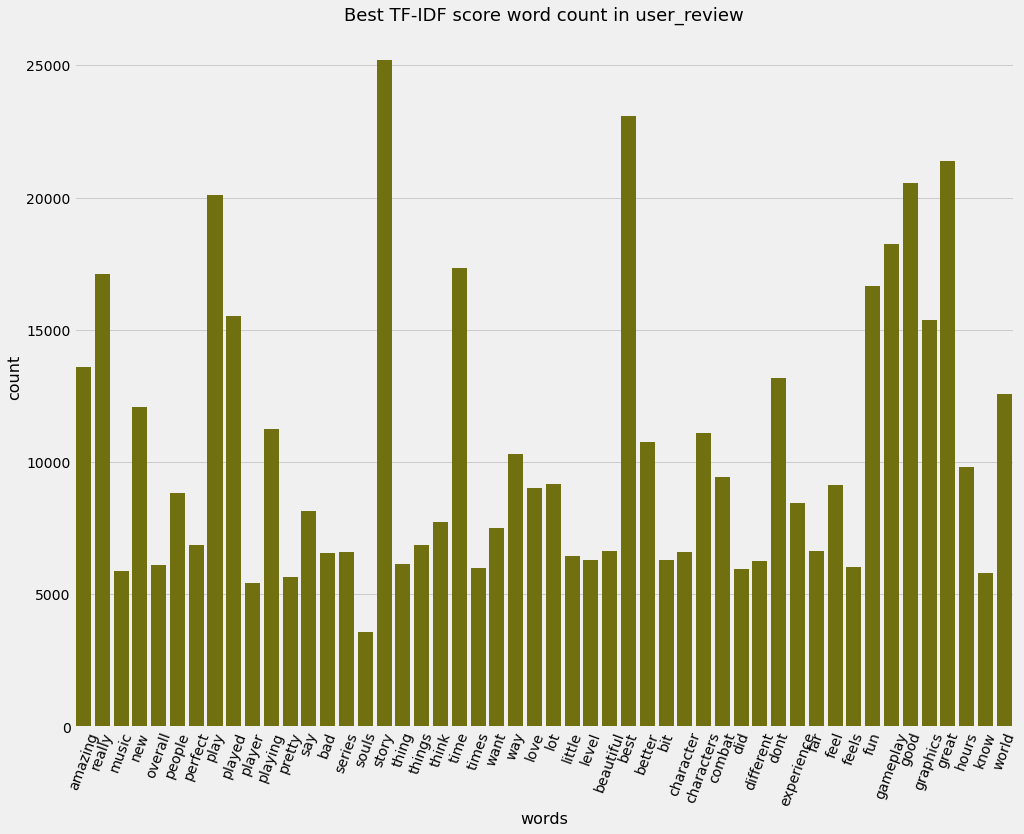

In [33]:
plt.figure(figsize=(15,12))
sns.barplot(x=top_22_tfidf_words_rev, y=top_22_tfidf_words_rev_count, color='olive')
plt.title('Best TF-IDF score word count in user_review', fontsize=18)

plt.ylabel('count', fontsize=16)
plt.xlabel('words', fontsize=16)
plt.xticks(rotation=70, fontsize=14);

### From the plot above we can see that in our user_reviews the most occuring words with a TF-IDF score of 1 are 'story', 'best', and 'great'. These 3 words show up over 20k times in our corpus of user reviews.

## Now let's vectorize `summary`

In [34]:
# add 'game(s)' to stop words
my_stop_words = text.ENGLISH_STOP_WORDS.union(['game', 'games'])

tvec = TfidfVectorizer(stop_words=my_stop_words, 
                       strip_accents='ascii',
                       lowercase=True,
                       max_features=50, 
                       norm='l2', 
                       max_df=0.8,
                       smooth_idf=True)

tvec.fit(final_reviews_df['summary'])

TfidfVectorizer(max_df=0.8, max_features=50,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}),
                strip_accents='ascii')

### Convert matrix into a dataframe

In [35]:
df_summary_tvec = pd.DataFrame(tvec.transform(final_reviews_df['summary']).todense(), 
                               columns=tvec.get_feature_names())

In [36]:
top_15_tfidf_words = df_summary_tvec.max().sort_values(ascending=False)[:15].index
top_15_tfidf_words

Index(['make', 'journey', 'way', 'war', 'story', 'set', 'power', 'number',
       'new', 'like', 'world', 'dark', 'adventure', 'character', 'battle'],
      dtype='object')

### The above words all have a TF-IDF score of 1, which basically tells us that these terms that occur more frequently in particular summaries are likely more important than the terms that occur frequently in all of the corpus (all of the summaries). Let's plot the above to see what the value counts are in our dataset.

In [37]:
top_15_tfidf_words_counts = \
[df_summary_tvec[df_summary_tvec[word] > 0].shape[0] for word in top_15_tfidf_words]
top_15_tfidf_words_counts

[13682,
 10798,
 22356,
 9213,
 14682,
 17551,
 12337,
 36860,
 44933,
 8984,
 48694,
 13636,
 17814,
 8738,
 13444]

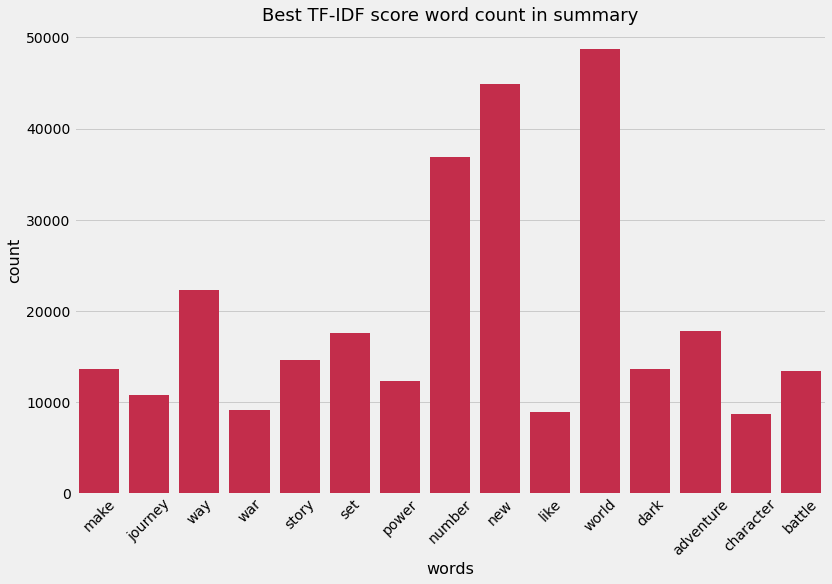

In [38]:
plt.figure(figsize=(12,8))
sns.barplot(x=top_15_tfidf_words, y=top_15_tfidf_words_counts, color='crimson')
plt.title('Best TF-IDF score word count in summary', fontsize=18)

plt.ylabel('count', fontsize=16)
plt.xlabel('words', fontsize=16)
plt.xticks(rotation=45, fontsize=14);

### From the above plot we can see that of all the words with a TF-IDF score of 1, 'world', 'new', and 'number' show up the most in our corpus. 'war', 'like', and 'character' show up the least with less than 10k occurances.

## Combine both tvec df into one

In [39]:
# change the name of summary tvec fd to be able to join
df_summary_tvec.columns = ['sum_' + col for col in df_summary_tvec.columns]

In [40]:
combined_df = df_summary_tvec.join(df_user_review_tvec)
combined_df.head()

,sum_abilities,sum_action,sum_adventure,sum_battle,sum_character,sum_characters,sum_city,sum_combat,sum_dark,sum_developed,...,souls,story,thing,things,think,time,times,want,way,world
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.294516,...,0.0,0.000000,0.000000,0.000000,0.0,0.487782,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.294516,...,0.0,0.062584,0.000000,0.195353,0.0,0.217961,0.101365,0.190463,0.346986,0.162609
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.294516,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.294516,...,0.0,0.000000,0.000000,0.000000,0.0,0.328686,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.294516,...,0.0,0.242787,0.390407,0.000000,0.0,0.281853,0.000000,0.000000,0.000000,0.000000


### Check to see if there are any null values

In [41]:
combined_df.isnull().sum()

sum_abilities    0
sum_action       0
sum_adventure    0
sum_battle       0
sum_character    0
                ..
time             0
times            0
want             0
way              0
world            0
Length: 100, dtype: int64

In [42]:
combined_df

,sum_abilities,sum_action,sum_adventure,sum_battle,sum_character,sum_characters,sum_city,sum_combat,sum_dark,sum_developed,...,souls,story,thing,things,think,time,times,want,way,world
0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.294516,...,0.0,0.000000,0.000000,0.000000,0.000000,0.487782,0.000000,0.000000,0.000000,0.000000
1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.294516,...,0.0,0.062584,0.000000,0.195353,0.000000,0.217961,0.101365,0.190463,0.346986,0.162609
2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.294516,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.294516,...,0.0,0.000000,0.000000,0.000000,0.000000,0.328686,0.000000,0.000000,0.000000,0.000000
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.294516,...,0.0,0.242787,0.390407,0.000000,0.000000,0.281853,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94330,0.0,0.512122,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.788248,0.000000,0.000000,0.000000,0.000000,0.000000
94331,0.0,0.000000,0.871138,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
94332,0.0,0.000000,0.871138,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
94333,0.0,0.000000,0.871138,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Our combined df is all good, let's merge it to the final one and drop the `summary` and `user_review` columns

In [43]:
# save df for further NLP like stem/lemmatizing
final_reviews_df.to_csv('../data/df_for_further_nlp.csv', index=False)
final_reviews_df.head(3)

,summary,num_players,critic_score,avg_user_score,user_review,user_score,target,console_ps4,console_ps5,console_switch,console_xbox-series-x,console_xboxone,rating_E10+,rating_M,rating_T,video_game_name_in_top_40,developer_in_top_25,genre_in_top_20
0,developed by the creators of grand theft auto ...,32,97,8.6,this site is a joke this the first time when i...,9,1,1,0,0,0,0,0,1,0,1,1,1
1,developed by the creators of grand theft auto ...,32,97,8.6,fair review of rdr2 im almost <number> finishe...,7,1,1,0,0,0,0,0,1,0,1,1,1
2,developed by the creators of grand theft auto ...,32,97,8.6,i really wanted to love it the overworld is be...,6,1,1,0,0,0,0,0,1,0,1,1,1


In [44]:
 final_reviews_df = final_reviews_df.drop(columns=['summary', 'user_review']).join(combined_df)

In [45]:
final_reviews_df

,num_players,critic_score,avg_user_score,user_score,target,console_ps4,console_ps5,console_switch,console_xbox-series-x,console_xboxone,...,souls,story,thing,things,think,time,times,want,way,world
0,32,97,8.6,9,1,1,0,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.487782,0.000000,0.000000,0.000000,0.000000
1,32,97,8.6,7,1,1,0,0,0,0,...,0.0,0.062584,0.000000,0.195353,0.000000,0.217961,0.101365,0.190463,0.346986,0.162609
2,32,97,8.6,6,1,1,0,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,32,97,8.6,7,1,1,0,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.328686,0.000000,0.000000,0.000000,0.000000
4,32,97,8.6,7,1,1,0,0,0,0,...,0.0,0.242787,0.390407,0.000000,0.000000,0.281853,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94330,1,78,6.8,7,0,0,1,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.788248,0.000000,0.000000,0.000000,0.000000,0.000000
94331,1,78,7.9,10,0,0,1,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
94332,1,78,7.9,10,0,0,1,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
94333,1,78,7.9,10,0,0,1,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Let's take a look at our target columns and address any imbalance present

In [46]:
final_reviews_df.target.value_counts()

1    54451
0    39884
Name: target, dtype: int64

### Our targets are a bit imbalanced, with over 10k more 1s than 0s (above/below median avg_user_score). To combat this we are going to down sample rows with target of 1 to get a balanced target.

In [47]:
# randomly sample the same number of rows above target to get equal number of rows with below target 
random_target_1s = final_reviews_df[final_reviews_df.target == 1].sample(n=39884, replace=True)

In [48]:
# drop rows where target = 1
final_reviews_df.drop(final_reviews_df[final_reviews_df.target == 1].index, inplace=True)

In [49]:
final_df_modeling = pd.concat([final_reviews_df, random_target_1s], ignore_index=True)

In [50]:
final_df_modeling.head()

,num_players,critic_score,avg_user_score,user_score,target,console_ps4,console_ps5,console_switch,console_xbox-series-x,console_xboxone,...,souls,story,thing,things,think,time,times,want,way,world
0,30,97,8.3,6,0,1,0,0,0,0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
1,30,97,8.3,10,0,1,0,0,0,0,...,0.0,0.000000,0.0,0.417952,0.0,0.000000,0.000000,0.0,0.000000,0.0
2,30,97,8.3,7,0,1,0,0,0,0,...,0.0,0.147287,0.0,0.229875,0.0,0.170985,0.000000,0.0,0.000000,0.0
3,30,97,8.3,10,0,1,0,0,0,0,...,0.0,0.000000,0.0,0.637094,0.0,0.000000,0.000000,0.0,0.000000,0.0
4,30,97,8.3,4,0,1,0,0,0,0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.204101,0.0,0.174666,0.0


## Save the final dataframe for modeling to a .csv file

In [51]:
final_df_modeling.to_csv('../data/final_reviews_modeling.csv', index=False)